In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from ink_detection_utils import load_dataset
from ink_detection_utils import get_crop_numer_list
from ink_detection_utils import stitch_crops
from ink_detection_utils import load_volumes

from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
#UNet Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

import random

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [210]:
import random
import torchvision.transforms as T

class RandomChoice(T.RandomChoice):
    def __init__(self):
        super().__init__()
        self.t = random.choice(self.transforms)

    def __call__(self, img):
        return self.t(img)

In [211]:
test_img_1 = '../../Datasets/vesuvius-challenge-ink-detection/train/1/inkLabels.png'
test_img_2 = '../../Datasets/vesuvius-challenge-ink-detection/train/1/ir.png'

image_1 = Image.open(test_img_1)
image_2 = Image.open(test_img_2)

In [219]:
transform = transforms.Compose([
    transforms.RandomCrop(4000),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [220]:
seed = np.random.randint(2147483647) # make a seed with numpy generator
random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7

transformed_image_1 = transform(image_1)

In [221]:
random.seed(seed) # apply this seed to target tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7

transformed_image_2 = transform(image_2)

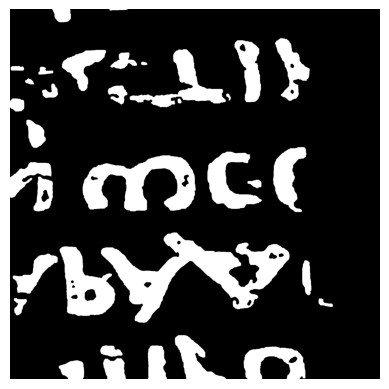

In [222]:
plt.imshow(transformed_image_1, cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

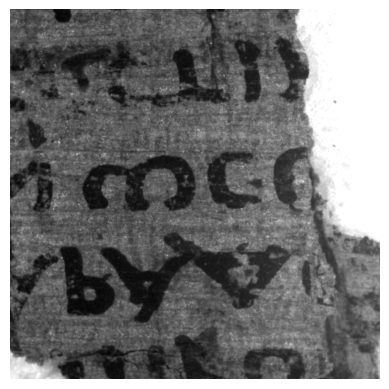

In [223]:
plt.imshow(transformed_image_2, cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

In [152]:
VESUVIUS_DATA_PATH = '../../Datasets/vesuvius-challenge-ink-detection/train/'

In [153]:
volume_paths = [VESUVIUS_DATA_PATH+'1/surface_volume/',VESUVIUS_DATA_PATH+'2/surface_volume/',VESUVIUS_DATA_PATH+'3/surface_volume/']
seg_paths = [VESUVIUS_DATA_PATH+'1/inkLabels.png',VESUVIUS_DATA_PATH+'2/inkLabels.png',VESUVIUS_DATA_PATH+'3/inkLabels.png']
mask_paths = [VESUVIUS_DATA_PATH+'1/mask.png',VESUVIUS_DATA_PATH+'2/mask.png',VESUVIUS_DATA_PATH+'3/mask.png']

In [267]:
class FragmentDataset(Dataset):
    def __init__(self, volume_paths, seg_paths, mask_paths, transform=None):
        self.volume_paths = volume_paths
        self.seg_paths = seg_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.volume_paths)

    def __getitem__(self, idx):
        volume_path = self.volume_paths[idx]
        seg_path = self.seg_paths[idx]
        mask_path = self.mask_paths[idx]

        image_paths = [os.path.join(volume_path, file) for file in os.listdir(volume_path) if file.endswith('.tif')]

        volume = []

        seed = np.random.randint(2147483647) # make a seed with numpy generator

        for image_path in image_paths:
            image = Image.open(image_path)
            if self.transform is not None:

                random.seed(seed)
                torch.manual_seed(seed)

                image = self.transform(image)
            image_array = np.array(image)
            volume.append(image_array)

        volume = np.stack(volume)

        seg = np.array(Image.open(seg_path))
        if self.transform is not None:

            random.seed(seed)
            torch.manual_seed(seed)

            seg = self.transform(seg)

        mask = np.array(Image.open(mask_path))
        if self.transform is not None:

            random.seed(seed)
            torch.manual_seed(seed)

            mask = self.transform(mask)


        return volume,seg, mask

In [268]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(2500),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create an instance of the FragmentDataset with the transformations
frag_data = FragmentDataset(volume_paths, seg_paths, mask_paths, transform=transform)

In [269]:
# Get an item from the dataset
idx = 0
volume, seg, mask = frag_data[idx]

# Print the shapes
print("Volume shape:", volume.shape)
print("Segment shape:", seg.shape)
print("Mask shape:", mask.shape)

Volume shape: (65, 1, 2500, 2500)
Segment shape: torch.Size([1, 2500, 2500])
Mask shape: torch.Size([1, 2500, 2500])


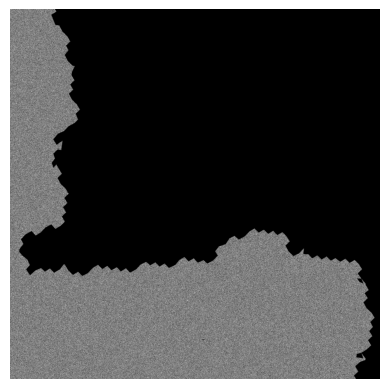

In [270]:
plt.imshow(volume[0][0], cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

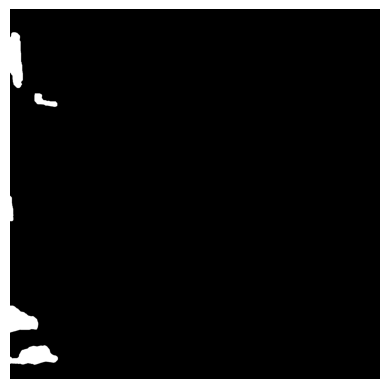

In [271]:
plt.imshow(seg[0], cmap="gray")
plt.axis("off")
plt.show()

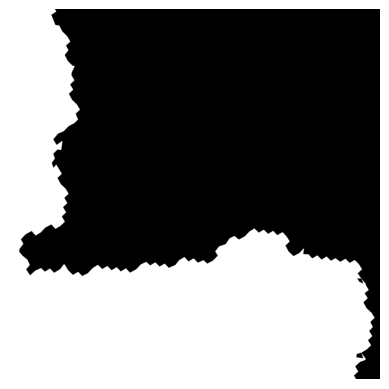

In [272]:
plt.imshow(mask[0], cmap="gray")
plt.axis("off")
plt.show()